# Learn a Reward Function using Maximum Conditional Entropy Inverse Reinforcement Learning

MCE IRL only supports tabular environments.

The cliffworld environment, that we use here is a TabularEnvironment.
It's observations consist of the POMDP's observations and the actual state.
We later also need VecEnv objects that expose just the internal POMDP-state or just the POMDP-observation as its observation.

In [1]:
from imitation.algorithms.mce_irl import (
    MCEIRL,
    mce_occupancy_measures,
    mce_partition_fh,
    TabularPolicy,
)
import gym
import numpy as np

from imitation.data import rollout
from imitation.envs import resettable_env
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.rewards import reward_nets
from imitation.rewards.reward_wrapper import RewardVecEnvWrapper
from imitation.envs.examples.model_envs import CliffWorld


env_name = "imitation/CliffWorld100x20-v0"

env : CliffWorld = gym.make(env_name)
state_venv = resettable_env.DictExtractWrapper(
    DummyVecEnv([lambda: gym.make(env_name)] * 4), "state"
)
obs_venv = resettable_env.DictExtractWrapper(
    DummyVecEnv([lambda: gym.make(env_name)] * 4), "obs"
)
print(env)

<OrderEnforcing<CliffWorld<imitation/CliffWorld100x20-v0>>>


Then we derive an expert policy using Bellman backups. We analytically compute the occupancy measures, and also sample some expert trajectories.

In [2]:
_, _, pi = mce_partition_fh(env)

_, om = mce_occupancy_measures(env, pi=pi)

expert = TabularPolicy(
    state_space=env.pomdp_state_space,
    action_space=env.action_space,
    pi=pi,
    rng=None,
)

expert_trajs = rollout.generate_trajectories(
    policy=expert,
    venv=state_venv,
    sample_until=rollout.make_min_timesteps(5000),
)

print("Expert stats: ", rollout.rollout_stats(expert_trajs))

Expert stats:  {'n_traj': 48, 'return_min': -54.0, 'return_mean': 1.2916666666666667, 'return_std': 12.022476057599597, 'return_max': 11.0, 'len_min': 110, 'len_mean': 110.0, 'len_std': 0.0, 'len_max': 110}


Finally, we set up the MCE algorithm and train it.

In [3]:
def train_mce_irl(demos, **kwargs):
    reward_net = reward_nets.BasicRewardNet(
        env.pomdp_observation_space,
        env.action_space,
        use_action=False,
        use_next_state=False,
        use_done=False,
        hid_sizes=[],
    )

    mce_irl = MCEIRL(demos, env, reward_net, linf_eps=1e-3)
    mce_irl.train(**kwargs)

    imitation_trajs = rollout.generate_trajectories(
        policy=mce_irl.policy,
        venv=state_venv,
        sample_until=rollout.make_min_timesteps(5000),
    )
    print("Imitation stats: ", rollout.rollout_stats(imitation_trajs))

    return mce_irl

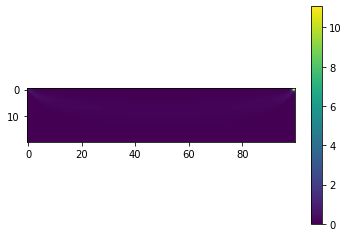

In [4]:
env.draw_value_vec(om)

First, we train it on the analytically computed occupancy measures. This should give a very precise result.

In [5]:
mce_irl_from_om = train_mce_irl(np.nan_to_num(om, nan=0))

--------------------------
| grad_norm   | 20.3     |
| iteration   | 0        |
| linf_delta  | 11.1     |
| weight_norm | 0.726    |
--------------------------
--------------------------
| grad_norm   | 11.3     |
| iteration   | 100      |
| linf_delta  | 11.1     |
| weight_norm | 19.1     |
--------------------------
--------------------------
| grad_norm   | 9.33     |
| iteration   | 200      |
| linf_delta  | 9.3      |
| weight_norm | 25.4     |
--------------------------
--------------------------
| grad_norm   | 5.68     |
| iteration   | 300      |
| linf_delta  | 5.63     |
| weight_norm | 29       |
--------------------------
--------------------------
| grad_norm   | 2.81     |
| iteration   | 400      |
| linf_delta  | 2.76     |
| weight_norm | 31.1     |
--------------------------
--------------------------
| grad_norm   | 1.59     |
| iteration   | 500      |
| linf_delta  | 1.55     |
| weight_norm | 32.3     |
--------------------------
--------------------------
|

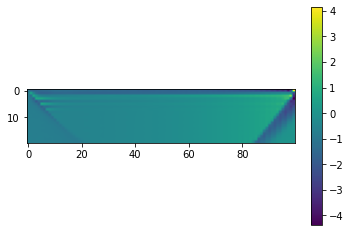

In [6]:
r_pred_from_om = mce_irl_from_om.get_predicted_r()
env.draw_value_vec(r_pred_from_om)

Then we train it on trajectories sampled from the expert. This gives a stochastic approximation to occupancy measure, so performance is a little worse. Using more expert trajectories should improve performance -- try it!

In [7]:
mce_irl_from_trajs = train_mce_irl(expert_trajs[0:10])

--------------------------
| grad_norm   | 20.2     |
| iteration   | 0        |
| linf_delta  | 11.5     |
| weight_norm | 0.658    |
--------------------------
--------------------------
| grad_norm   | 12       |
| iteration   | 100      |
| linf_delta  | 11.5     |
| weight_norm | 35.4     |
--------------------------
--------------------------
| grad_norm   | 10.7     |
| iteration   | 200      |
| linf_delta  | 10.5     |
| weight_norm | 65.4     |
--------------------------
--------------------------
| grad_norm   | 8.72     |
| iteration   | 300      |
| linf_delta  | 8.49     |
| weight_norm | 89.2     |
--------------------------
--------------------------
| grad_norm   | 6.53     |
| iteration   | 400      |
| linf_delta  | 6.25     |
| weight_norm | 112      |
--------------------------
--------------------------
| grad_norm   | 5.46     |
| iteration   | 500      |
| linf_delta  | 5.13     |
| weight_norm | 134      |
--------------------------
--------------------------
|

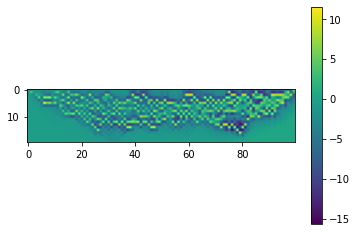

In [8]:
r_pred_from_trajs = mce_irl_from_trajs.get_predicted_r()
env.draw_value_vec(r_pred_from_trajs)

In [9]:
import numpy as np
r_pred_from_trajs = np.nan_to_num(r_pred_from_trajs, nan=-1)
assert not np.isnan(r_pred_from_trajs).any()
test_env_name = "imitation/CliffWorld100x20-v0"
test_env = gym.make(test_env_name)
test_venv = resettable_env.DictExtractWrapper(
    DummyVecEnv([lambda: gym.make(test_env_name)] * 4), "state"
)

_, _, pi_learner = mce_partition_fh(test_env, reward=r_pred_from_trajs)

_, om_learner = mce_occupancy_measures(test_env, pi=pi_learner, reward=r_pred_from_trajs)

learner = TabularPolicy(
    state_space=test_env.pomdp_state_space,
    action_space=test_env.action_space,
    pi=pi_learner,
    rng=None,
)

learner_trajs = rollout.generate_trajectories(
    policy=learner,
    venv=test_venv,
    sample_until=rollout.make_min_timesteps(5000),
)

print("Learner stats: ", rollout.rollout_stats(learner_trajs))


ValueError: could not broadcast input array from shape (2000,1) into shape (90,4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


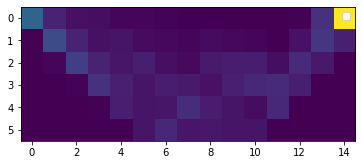

In [ ]:
test_env.draw_value_vec(om_learner)